Note : Remove the warm-up time for any experiments, including our project cause if we keep it, it could skew the results very much

In [19]:
import os
import sys
from contextlib import contextmanager, redirect_stdout
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np
import simpy
from matplotlib.axes import Axes
from matplotlib.figure import Figure

RNG = np.random.default_rng(seed=0) 


@contextmanager
def suppress_print():
    """Temporarily disable print statements."""
    with redirect_stdout(open(os.devnull, "w")):
        yield

# 1. Closed Queuing network simulation (17 pt)

Build a simulator to capture the following system and answer the questions below. A total of N=40 jobs circulate in different parts of the systems: CPU, disk, and resting area. There is one CPU and two disks, one slow and one fast. Each job starts at the CPU station and takes an average of 2 seconds. After CPU, a job fetches the data from the disk, needing an average of 3000 disk cycles. There are two possible choices of disks, fast and slow, which have a speed of 1000 cycles per second and 100 cycles per seconds, respectively. After the disk station, the job can rest for 15 seconds on average. The figure below gives an overview of the system:

The choices of distributions are up to you. You are welcomed to try different distributions to answer the following questions and assess the impact of different variants.


### Distribution: Exponential

In [20]:
class ClosedQueuingNet:
    """
    Closed queuing network with:
    - CPU (1 server)
    - 1 or 2 fast disks 
    - Slow disk (1 server)
    - Rest area (infinite server)
    - N circulating jobs
    - No warmup
    """

    def __init__(
        self,
        env: simpy.Environment,
        strategy: str, # represents the chosen strategy
        num_fast_disks: int, # number of fast disks 
        # According to the given number of disks (1 or 2), a block of code will be executed.
        # The idea behind it was the fact that in qu. 1 & 2 we need 1 fast disk and in qu. 3 & 4 we need 2. 
        # So instead of commenting/uncommenting the code each time, we set in place this element in the code         
        N: int = 40,
        mu_cpu: float = 2.0,
        disk_cycles: float = 3000.0,
        speed_fast_1: float = 1000.0,
        speed_fast_2: float = 1000.0,
        speed_slow: float = 100.0,
        mu_rest: float = 15.0,
    ):
        self.env = env
        self.strategy = strategy
        self.num_fast_disks = num_fast_disks
        self.N = N

        # Mean service times
        self.mu_cpu = mu_cpu
        self.mu_disk_fast = disk_cycles / speed_fast_1
        self.mu_disk_slow = disk_cycles / speed_slow
        self.mu_rest = mu_rest

        # Resources
        self.cpu = simpy.Resource(self.env, capacity=1)

        if self.num_fast_disks == 1:
            self.disk_fast = simpy.Resource(self.env, capacity=1)
        elif self.num_fast_disks == 2:
            self.disk_fast_1 = simpy.Resource(self.env, capacity=1)
            self.disk_fast_2 = simpy.Resource(self.env, capacity=1)
        else:
            raise ValueError("num_fast_disks must be 1 or 2")

        self.disk_slow = simpy.Resource(self.env, capacity=1)

        # Statistics
        self.completed_cycles = 0
        self.sum_cycle_times = 0.0
        self.response_time_acc = 0.0

        self.cpu_busy = 0.0
        self.disk_fast_busy = 0.0
        self.disk_fast_1_busy = 0.0
        self.disk_fast_2_busy = 0.0
        self.disk_slow_busy = 0.0

    def job(self, job_id: int) -> Generator:
        while True:
            cycle_start = self.env.now

            # ===== CPU =====
            req = self.cpu.request()
            yield req
            start = self.env.now
            yield self.env.timeout(RNG.exponential(self.mu_cpu))
            end = self.env.now
            self.cpu.release(req)
            self.cpu_busy += end - start

            # ===== Disk selection =====
            if self.num_fast_disks == 1: # For questions 1 & 2
                
                if self.strategy == "random":
                    if RNG.choice(["fast", "slow"]) == "fast":
                        disk = self.disk_fast
                        mean = self.mu_disk_fast 
                        busy_attr = "disk_fast_busy"
                    else:
                        disk = self.disk_slow
                        mean = self.mu_disk_slow
                        busy_attr = "disk_slow_busy"

                elif self.strategy == "queue_aware":
                    load_fast = len(self.disk_fast.queue) + self.disk_fast.count
                    load_slow = len(self.disk_slow.queue) + self.disk_slow.count

                    if load_fast <= load_slow:
                        disk = self.disk_fast
                        mean = self.mu_disk_fast
                        busy_attr = "disk_fast_busy"
                    else:
                        disk = self.disk_slow
                        mean = self.mu_disk_slow
                        busy_attr = "disk_slow_busy"

            else:
                # Questions 3 & 4
                if self.strategy == "random":
                    choice = RNG.choice(["fast1", "fast2", "slow"])
                else:
                    loads = {
                        "fast1": len(self.disk_fast_1.queue) + self.disk_fast_1.count,
                        "fast2": len(self.disk_fast_2.queue) + self.disk_fast_2.count,
                        "slow":  len(self.disk_slow.queue) + self.disk_slow.count,
                    }
                    choice = min(loads, key=loads.get)

                if choice == "fast1":
                    disk = self.disk_fast_1
                    mean = self.mu_disk_fast # we don't have to define a self.mu_disk_fast_1 because it's going to have the same value anyways
                    busy_attr = "disk_fast_1_busy"
                elif choice == "fast2":
                    disk = self.disk_fast_2
                    mean = self.mu_disk_fast # Same thing here
                    busy_attr = "disk_fast_2_busy"
                else:
                    disk = self.disk_slow
                    mean = self.mu_disk_slow
                    busy_attr = "disk_slow_busy"

            # ===== Disk service =====
            req = disk.request()
            yield req
            start = self.env.now
            yield self.env.timeout(RNG.exponential(mean))
            end = self.env.now
            disk.release(req)

            if busy_attr == "disk_fast_busy":
                self.disk_fast_busy += end - start
            elif busy_attr == "disk_fast_1_busy":
                self.disk_fast_1_busy += end - start
            elif busy_attr == "disk_fast_2_busy":
                self.disk_fast_2_busy += end - start
            else:
                self.disk_slow_busy += end - start

            # ===== Rest =====
            yield self.env.timeout(RNG.exponential(self.mu_rest))

            # ===== Cycle complete =====
            self.completed_cycles += 1
            cycle_time = self.env.now - cycle_start
            self.sum_cycle_times += cycle_time
            self.response_time_acc += cycle_time

    def run(self, t: float):
        """
        Run the system for total time t (no warmup).
        """

        # Start all N circulating job processes
        for j in range(self.N):
            self.env.process(self.job(j))

        # Run until the end of simulation
        self.env.run(until=t)

        # ===== Statistics =====
        throughput = self.completed_cycles / t # throughput = self.N / self.env.now
        avg_cycle_time = self.sum_cycle_times / self.completed_cycles
        responce_time = self.response_time_acc / self.completed_cycles

        util_cpu = self.cpu_busy / t
        util_fast = self.disk_fast_busy / t
        util_fast_1 = self.disk_fast_1_busy / t
        util_fast_2 = self.disk_fast_2_busy / t
        util_slow = self.disk_slow_busy / t

        if self.num_fast_disks == 1:
            return {
                "completed_cycles": self.completed_cycles,
                "throughput": throughput,
                "response_time": responce_time,
                "cpu_util": util_cpu,
                "fast_disk_util": util_fast,
                "slow_disk_util": util_slow,
            }
        elif self.num_fast_disks == 2:
            return {
                "completed_cycles": self.completed_cycles,
                "throughput": throughput,
                "response_time": responce_time,
                "cpu_util": util_cpu,
                "fast_1_util": util_fast_1,
                "fast_2_util": util_fast_2,
                "slow_disk_util": util_slow,
            }

In [21]:
# The purpose of this function is to run the two strategies in the same time and have both results displayed 
# instead commenting/uncommenting each strategy everytime we want to use one of them.
# It's defined outside the class because it (function) calls it (class) in it (function)

def run_both_strategies(mu_cpu: float , num_fast_disks: int, t: float): 
        results = {}

        for strategy in ["random", "queue_aware"]:
            env = simpy.Environment()
            sim = ClosedQueuingNet(env, strategy=strategy, num_fast_disks=num_fast_disks ,mu_cpu=mu_cpu)

            with suppress_print():  # optional
                res = sim.run(t)

            results[strategy] = res

        # Print side-by-side summary
        print("\n STRATEGY COMPARAISON")
        if num_fast_disks == 1:
             for strategy, res in results.items():
                print(f"\nStrategy: {strategy}")
                print(f"  Completed cycles: {res['completed_cycles']}")
                print(f"  Throughput (jobs/s): {res['throughput']:.6f}")
                print(f"  Response time: {res['response_time']:.6f}")
                print(f"  CPU util: {res['cpu_util']:.6f}")
                print(f"  Fast disk util: {res['fast_disk_util']:.6f}")
                print(f"  Slow disk util: {res['slow_disk_util']:.6f}")

        elif num_fast_disks == 2:
            for strategy, res in results.items():
                print(f"\nStrategy: {strategy}")
                print(f"  Completed cycles: {res['completed_cycles']}")
                print(f"  Throughput (jobs/s): {res['throughput']:.6f}")
                print(f"  Response time: {res['response_time']:.6f}")
                print(f"  CPU util: {res['cpu_util']:.6f}")
                print(f"  Fast disk 1 util: {res['fast_1_util']:.6f}")
                print(f"  Fast disk 2 util: {res['fast_2_util']:.6f}")
                print(f"  Slow disk util: {res['slow_disk_util']:.6f}")



        return results



## Question 1

In [22]:
# IMPORTANT: NEVER RUN THISE CELLS ALONE!
# To have the same result each time for this type of code cell, run the WHOLE notebook (Run All).
# Otherwise (if you only run this cell ), you'll get a different result each time

results_1 = run_both_strategies(t=10_000, mu_cpu=2.0, num_fast_disks=1)


 STRATEGY COMPARAISON

Strategy: random
  Completed cycles: 657
  Throughput (jobs/s): 0.065700
  Response time: 571.454437
  CPU util: 0.135163
  Fast disk util: 0.100801
  Slow disk util: 0.998804

Strategy: queue_aware
  Completed cycles: 3741
  Throughput (jobs/s): 0.374100
  Response time: 105.101074
  CPU util: 0.746783
  Fast disk util: 0.995487
  Slow disk util: 0.991470


## Question 2

In [23]:
results_2 = run_both_strategies(t=10_000, mu_cpu=1.0, num_fast_disks=1)


 STRATEGY COMPARAISON

Strategy: random
  Completed cycles: 704
  Throughput (jobs/s): 0.070400
  Response time: 532.158999
  CPU util: 0.075514
  Fast disk util: 0.111449
  Slow disk util: 0.994189

Strategy: queue_aware
  Completed cycles: 3649
  Throughput (jobs/s): 0.364900
  Response time: 106.883181
  CPU util: 0.358766
  Fast disk util: 0.999436
  Slow disk util: 0.984439


## Question 3

In [24]:
results_3 = run_both_strategies(t=10_000, mu_cpu=2.0, num_fast_disks=2) # Back to the average cpu value set at the start 


 STRATEGY COMPARAISON

Strategy: random
  Completed cycles: 1015
  Throughput (jobs/s): 0.101500
  Response time: 367.740966
  CPU util: 0.225375
  Fast disk 1 util: 0.102033
  Fast disk 2 util: 0.101166
  Slow disk util: 0.997940

Strategy: queue_aware
  Completed cycles: 4894
  Throughput (jobs/s): 0.489400
  Response time: 81.244746
  CPU util: 0.999496
  Fast disk 1 util: 0.759846
  Fast disk 2 util: 0.619546
  Slow disk util: 0.936327


## Question 4

In [25]:
results_2 = run_both_strategies(t=10_000, mu_cpu=1.0, num_fast_disks=2) # for the cpu, like question 2


 STRATEGY COMPARAISON

Strategy: random
  Completed cycles: 1129
  Throughput (jobs/s): 0.112900
  Response time: 340.852460
  CPU util: 0.120578
  Fast disk 1 util: 0.119086
  Fast disk 2 util: 0.116437
  Slow disk util: 0.996683

Strategy: queue_aware
  Completed cycles: 6969
  Throughput (jobs/s): 0.696900
  Response time: 56.845357
  CPU util: 0.701686
  Fast disk 1 util: 0.997830
  Fast disk 2 util: 0.997271
  Slow disk util: 0.987543


## Question 5

In [26]:
def run_over_N(
    N_values,
    mu_cpu,
    num_fast_disks,
    strategy="queue_aware",
    t=10_000,
):
    throughputs = []
    response_times = []

    for N in N_values:
        env = simpy.Environment()
        sim = ClosedQueuingNet(
            env=env,
            strategy=strategy,
            num_fast_disks=num_fast_disks,
            mu_cpu=mu_cpu,
            N=N,
        )

        with suppress_print():
            res = sim.run(t)

        throughputs.append(res["throughput"])
        response_times.append(res["response_time"])

    return np.array(throughputs), np.array(response_times)


In [27]:
N_values = [1, 2, 5, 10, 20, 30, 40, 60, 80, 100, 150, 200]

In [28]:
configs = {
    "Baseline (1 fast disk, CPU=2s)": {"mu_cpu": 2.0, "num_fast_disks": 1},
    "Faster CPU (1 fast disk, CPU=1s)": {"mu_cpu": 1.0, "num_fast_disks": 1},
    "2 Fast Disks (CPU=2s)": {"mu_cpu": 2.0, "num_fast_disks": 2},
    "Faster CPU + 2 Fast Disks": {"mu_cpu": 1.0, "num_fast_disks": 2},
}

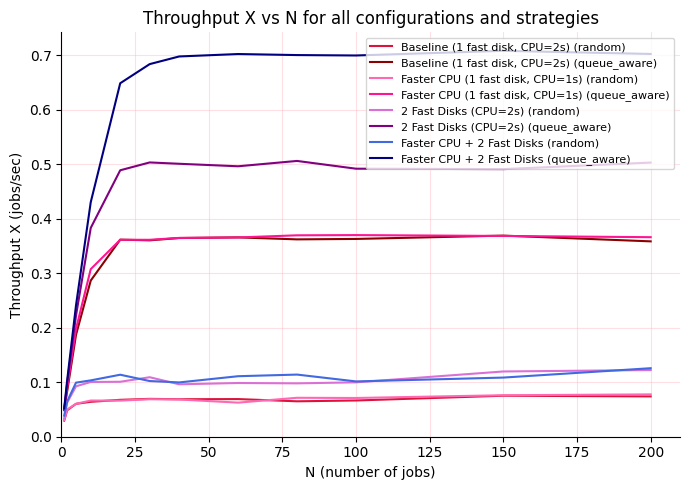

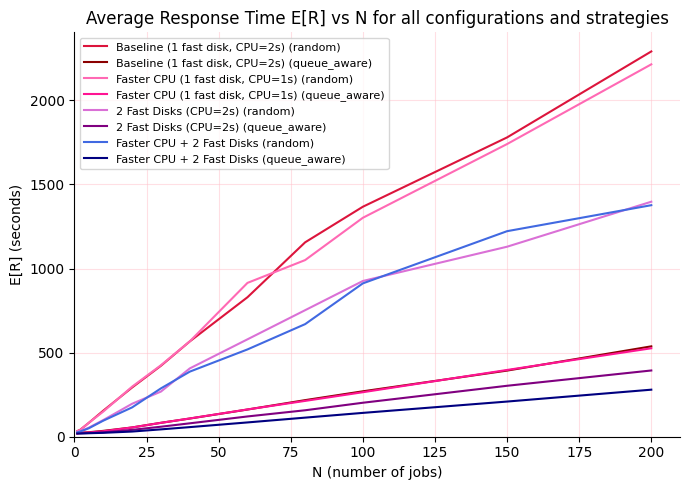

In [29]:
strategies = ["random", "queue_aware"]

results = {}

for strategy in strategies:
    for label, cfg in configs.items():
        X, R = run_over_N(
            N_values=N_values,
            mu_cpu=cfg["mu_cpu"],
            num_fast_disks=cfg["num_fast_disks"],
            strategy=strategy,
            t=20_000,
        )
        results[f"{label} ({strategy})"] = {"X": X, "R": R}

colors = {
    "Baseline (1 fast disk, CPU=2s) (random)": "crimson",
    "Baseline (1 fast disk, CPU=2s) (queue_aware)": "darkred",
    "Faster CPU (1 fast disk, CPU=1s) (random)": "hotpink",
    "Faster CPU (1 fast disk, CPU=1s) (queue_aware)": "deeppink",
    "2 Fast Disks (CPU=2s) (random)": "orchid",
    "2 Fast Disks (CPU=2s) (queue_aware)": "purple",
    "Faster CPU + 2 Fast Disks (random)": "royalblue",
    "Faster CPU + 2 Fast Disks (queue_aware)": "navy",
}

# Plot Throughput
fig, ax = plt.subplots(figsize=(7, 5))
for label, color in colors.items():
    ax.plot(N_values, results[label]["X"], color=color, label=label)
ax.set_xlabel("N (number of jobs)")
ax.set_ylabel("Throughput X (jobs/sec)")
ax.set_title("Throughput X vs N for all configurations and strategies")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(True, color="pink", alpha=0.5)
ax.legend(fontsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

# Plot Average Response Time
fig, ax = plt.subplots(figsize=(7, 5))
for label, color in colors.items():
    ax.plot(N_values, results[label]["R"], color=color, label=label)
ax.set_xlabel("N (number of jobs)")
ax.set_ylabel("E[R] (seconds)")
ax.set_title("Average Response Time E[R] vs N for all configurations and strategies")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(True, color="pink", alpha=0.5)
ax.legend(fontsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


The two figures show the system throughput and average response time as functions of the number of circulating jobs N for the four considered system configurations. For small values of N, throughput increases almost linearly, indicating that the system resources are not yet saturated and jobs experience little contention. As N grows, throughput gradually reaches a saturation point that depends on the system configuration, revealing the presence of bottleneck resources. In the baseline case, throughput saturates at the lowest level, while using a faster CPU or adding an extra fast disk increases the maximum achievable throughput. The highest throughput is observed when both a faster CPU and two fast disks are used, showing that removing multiple bottlenecks significantly improves system performance. The response time curves are consistent with this behavior. In fact, at low N, response times are relatively small, but once throughput saturates, response time increases rapidly as more jobs compete for the same limited resources. Configurations with higher throughput exhibit lower response times for all values of N, with the combined faster CPU and additional fast disk configuration providing the best overall performance. These results are consistent with the expected behavior of closed queuing networks and illustrate the trade‑off between system load, throughput, and response time.